# Выбор локации для скважины

#### Описание проекта 

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.
Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Данные геологоразведки трёх регионов находятся в файлах: 
+ [/datasets/geo_data_0.csv.](https://code.s3.yandex.net/datasets/geo_data_0.csv)
+ [/datasets/geo_data_1.csv.](https://code.s3.yandex.net/datasets/geo_data_1.csv)
+ [/datasets/geo_data_2.csv.](https://code.s3.yandex.net/datasets/geo_data_2.csv)

Где
+ `id` — уникальный идентификатор скважины
+ `f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы)
+ `product` — объём запасов в скважине (тыс. баррелей)

Разобъем задачу на два этапа:
1. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
2. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Для выбора локации определены следующие шаги:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

План работы:
1. Загрузка и подготовка данных
2. Обучение и проверка модели
3. Подготовка к расчёту прибыли
4. Расчёт прибыли и рисков
5. Вывод по работе

## 1. Загрузка и подготовка данных

### 1.1. Установка пакетов и импорт библиотек

#### 1.1.1. Установка пакета

In [1]:
!pip install phik -q

#### 1.1.2. Импорт библиотек

In [2]:
import time
start_time = time.time()
import os
import numpy as np
import pandas  as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import phik
from phik import phik_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
from sklearn.exceptions import FitFailedWarning 


from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (RandomizedSearchCV,
                                     train_test_split
                                    )
from sklearn.preprocessing import (MinMaxScaler,
                                   RobustScaler,
                                   StandardScaler
                                  )
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

### 1.2. Загрузка данных

In [3]:
pth1 = '/datasets/geo_data_0.csv'
pth2 = 'https://code.s3.yandex.net/datasets/geo_data_0.csv'

if os.path.exists(pth1):
    geo_data_0 = pd.read_csv(pth1, index_col='id')
else:
    geo_data_0 = pd.read_csv(pth2, index_col='id')
geo_data_0.head()

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
pth1 = '/datasets/geo_data_1.csv'
pth2 = 'https://code.s3.yandex.net/datasets/geo_data_1.csv'

if os.path.exists(pth1):
    geo_data_1 = pd.read_csv(pth1, index_col='id')
else:
    geo_data_1 = pd.read_csv(pth2, index_col='id')
geo_data_1.head()

,f0,f1,f2,product
id,,,,
kBEdx,-15.001348,-8.276000,-0.005876,3.179103
62mP7,14.272088,-3.475083,0.999183,26.953261
vyE1P,6.263187,-5.948386,5.001160,134.766305
KcrkZ,-13.081196,-11.506057,4.999415,137.945408
AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
pth1 = '/datasets/geo_data_2.csv'
pth2 = 'https://code.s3.yandex.net/datasets/geo_data_2.csv'

if os.path.exists(pth1):
    geo_data_2 = pd.read_csv(pth1, index_col='id')
else:
    geo_data_2 = pd.read_csv(pth2, index_col='id')
geo_data_2.head()

,f0,f1,f2,product
id,,,,
fwXo0,-1.146987,0.963328,-0.828965,27.758673
WJtFt,0.262778,0.269839,-2.530187,56.069697
ovLUW,0.194587,0.289035,-5.586433,62.871910
q6cA6,2.236060,-0.553760,0.930038,114.572842
WPMUX,-0.515993,1.716266,5.899011,149.600746


Данные загружены, можно переходить к предобработке.

### 1.3. Предобработка данных

In [6]:
geo_data_0.drop_duplicates().info()
geo_data_1.drop_duplicates().info()
geo_data_2.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, txEyH to 1CWhH
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, kBEdx to relB0
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1       100000 non-null  float64
 2   f2       100000 non-null  float64
 3   product  100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, fwXo0 to V9kWn
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   f0       100000 non-null  float64
 1   f1  

Проверим совпадение `id` в таблицах и устраним их добавлением номера таблицы.

In [7]:
print('Количество перекрестных совпадений "id" в  таблицах 0 и 1 = ', len(geo_data_0[geo_data_0.index.isin(geo_data_1.index.unique())]))
print('Количество перекрестных совпадений "id" в  таблицах 0 и 2 = ', len(geo_data_0[geo_data_0.index.isin(geo_data_2.index.unique())]))
print('Количество перекрестных совпадений "id" в  таблицах 1 и 2= ', len(geo_data_1[geo_data_1.index.isin(geo_data_2.index.unique())]))

Количество перекрестных совпадений "id" в  таблицах 0 и 1 =  10
Количество перекрестных совпадений "id" в  таблицах 0 и 2 =  17
Количество перекрестных совпадений "id" в  таблицах 1 и 2=  4


Пропуски в данных отсутствуют, типы данных соответствуют содержанию. Совпадающие индексы скважин по регионам пока оставим без изменения. Можно переходить к исследовательскому анализу.

### 1.4. Исследовательский анализ данных

In [8]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [9]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [10]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Исследование параметра `f0`.

In [11]:
def f_hist_box_1(hb1, bins, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,5), gridspec_kw={"height_ratios": (.15, .85)})
     
    sns.boxplot(data=[hb1], orient="h", ax=ax_box)
    plt.hist([hb1], 
             bins=bins, range=(hb1.min(), hb1.max()), label=hb1.name)
 
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

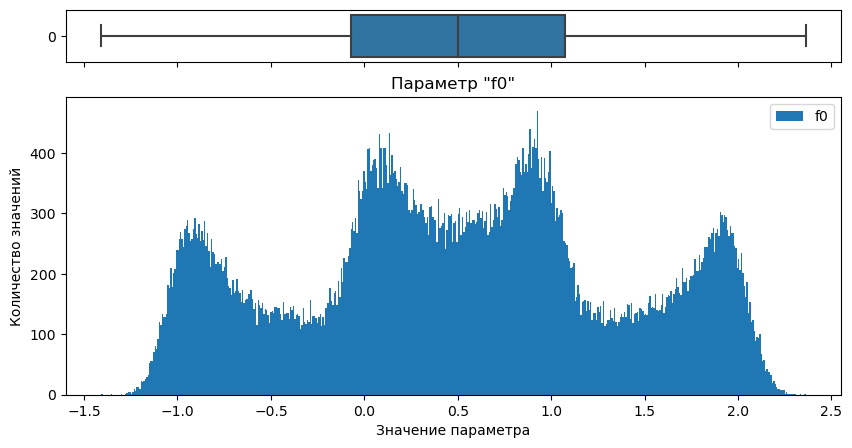

In [12]:
f_hist_box_1(
    hb1=geo_data_0['f0'],
    bins=500,   
    title='Параметр "f0"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

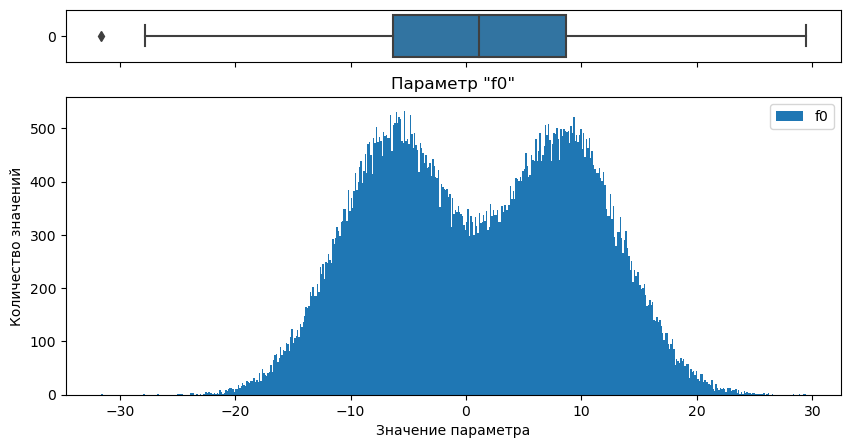

In [13]:
f_hist_box_1(
    hb1=geo_data_1['f0'],
    bins=500,   
    title='Параметр "f0"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

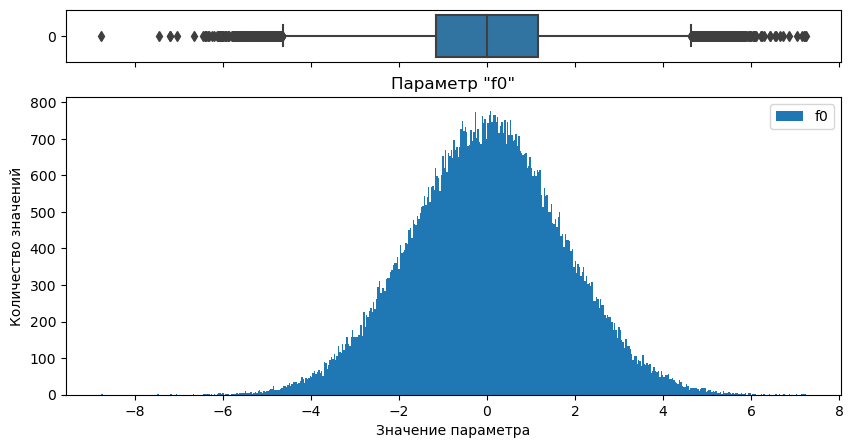

In [14]:
f_hist_box_1(
    hb1=geo_data_2['f0'],
    bins=500,   
    title='Параметр "f0"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Сопоставим данные.

In [15]:
def f_hist_box_3(hb1, hb2, hb3, bins, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(10,5), gridspec_kw={"height_ratios": (.15, .85)})
     
    sns.boxplot(data=[hb1, hb2, hb3], orient="h", ax=ax_box)
    plt.hist([hb1, hb2, hb3], 
             bins=bins, range=(min(hb1.min(), hb2.min(), hb3.min()), max(hb1.max(), hb2.max(), hb3.max())), 
             label=['geo_data_0', 'geo_data_1', 'geo_data_2'])
 
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

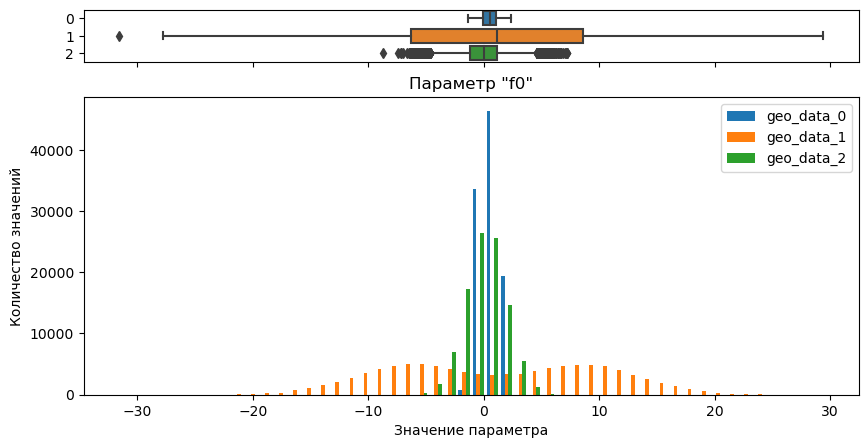

In [16]:
f_hist_box_3(
    hb1=geo_data_0['f0'],
    hb2=geo_data_1['f0'],
    hb3=geo_data_2['f0'],
    bins=50,
    title='Параметр "f0"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Исследование параметра `f1`.

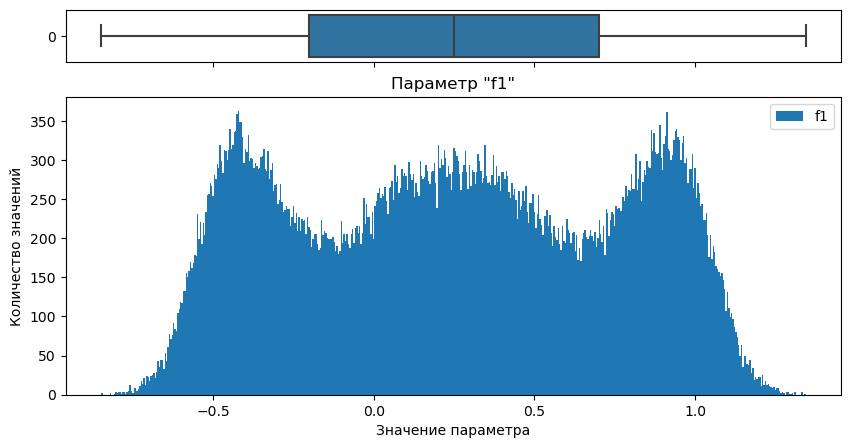

In [17]:
f_hist_box_1(
    hb1=geo_data_0['f1'],
    bins=500,   
    title='Параметр "f1"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

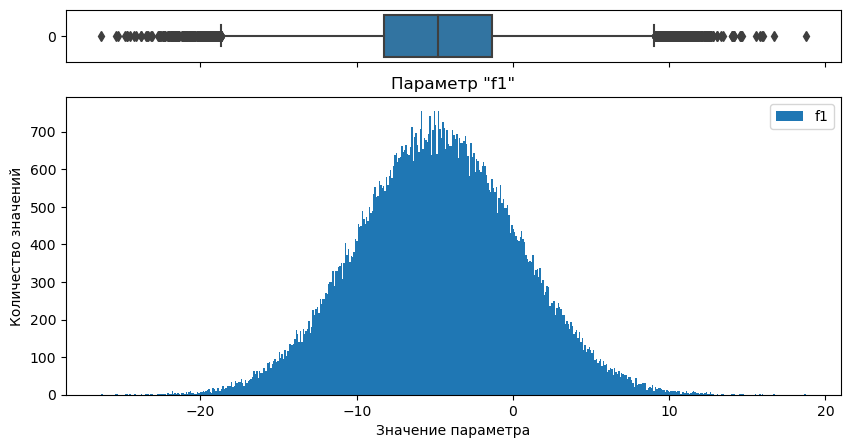

In [18]:
f_hist_box_1(
    hb1=geo_data_1['f1'],
    bins=500,   
    title='Параметр "f1"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

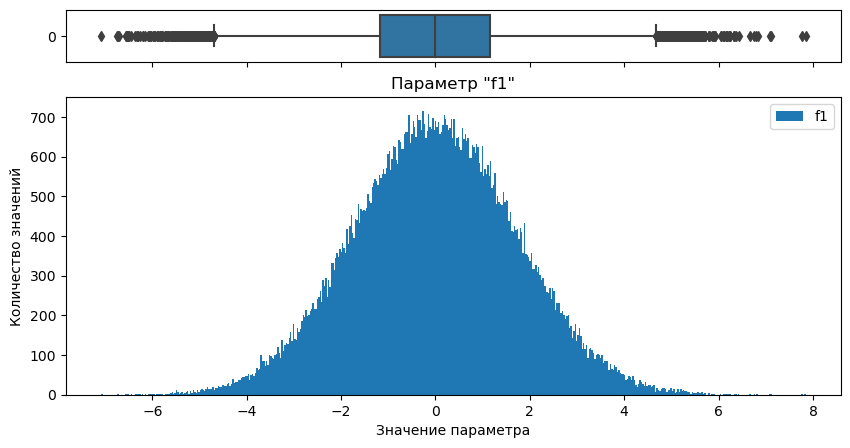

In [19]:
f_hist_box_1(
    hb1=geo_data_2['f1'],
    bins=500,   
    title='Параметр "f1"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Сопоставим данные.

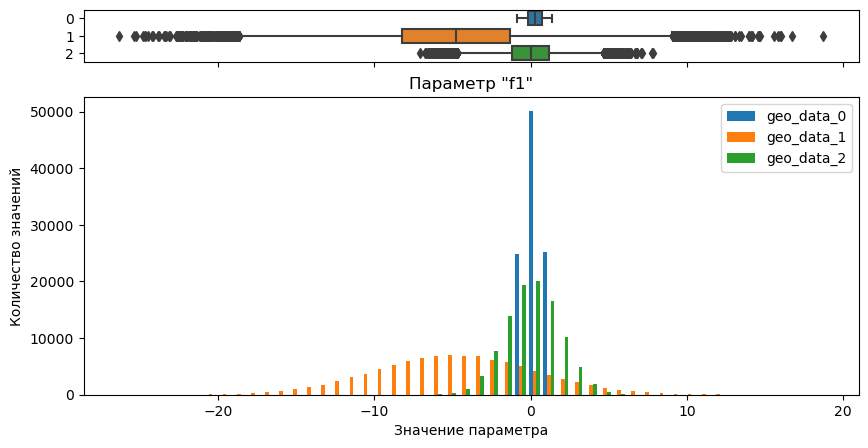

In [20]:
f_hist_box_3(
    hb1=geo_data_0['f1'],
    hb2=geo_data_1['f1'],
    hb3=geo_data_2['f1'],
    bins=50,
    title='Параметр "f1"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Исследование параметра `f2`.

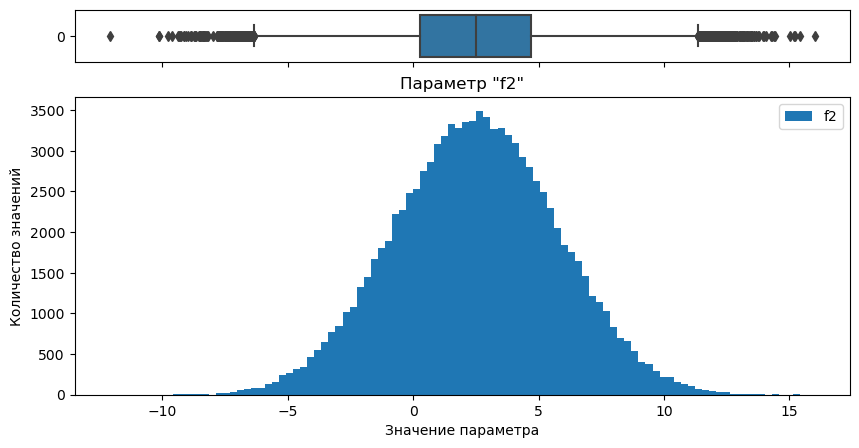

In [21]:
f_hist_box_1(
    hb1=geo_data_0['f2'],
    bins=100,   
    title='Параметр "f2"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

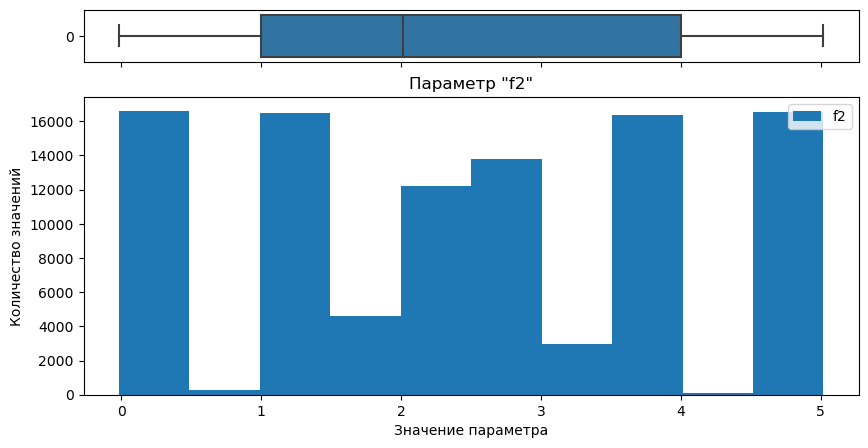

In [22]:
f_hist_box_1(
    hb1=geo_data_1['f2'],
    bins=10,   
    title='Параметр "f2"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

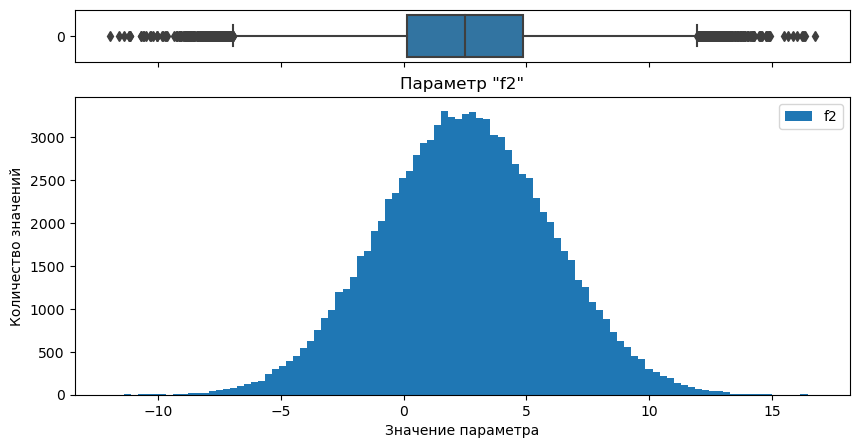

In [23]:
f_hist_box_1(
    hb1=geo_data_2['f2'],
    bins=100,   
    title='Параметр "f2"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Сопоставим данные.

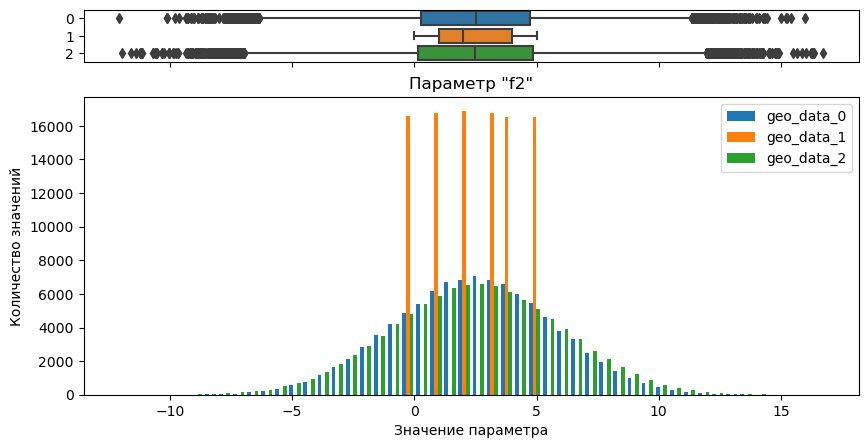

In [24]:
f_hist_box_3(
    hb1=geo_data_0['f2'],
    hb2=geo_data_1['f2'],
    hb3=geo_data_2['f2'],
    bins=50,
    title='Параметр "f2"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Исследование параметра `product`.

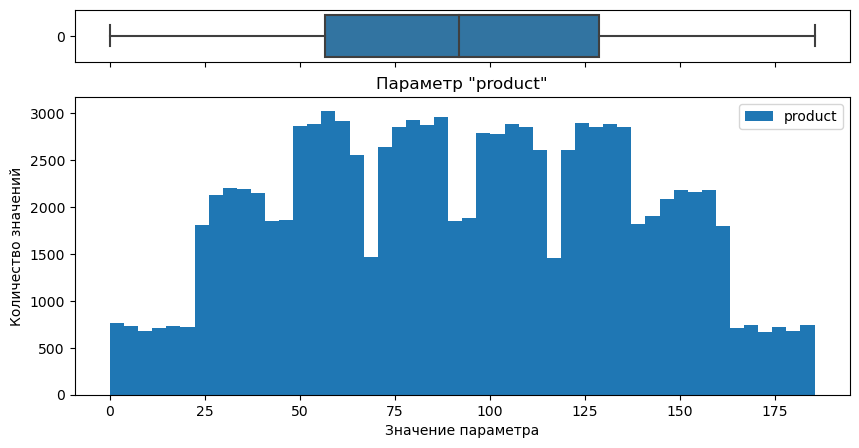

In [25]:
f_hist_box_1(
    hb1=geo_data_0['product'],
    bins=50,   
    title='Параметр "product"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

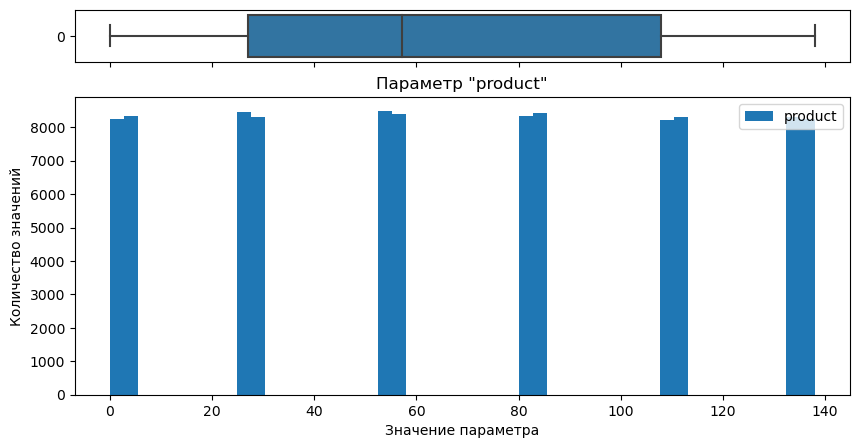

In [26]:
f_hist_box_1(
    hb1=geo_data_1['product'],
    bins=50,   
    title='Параметр "product"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

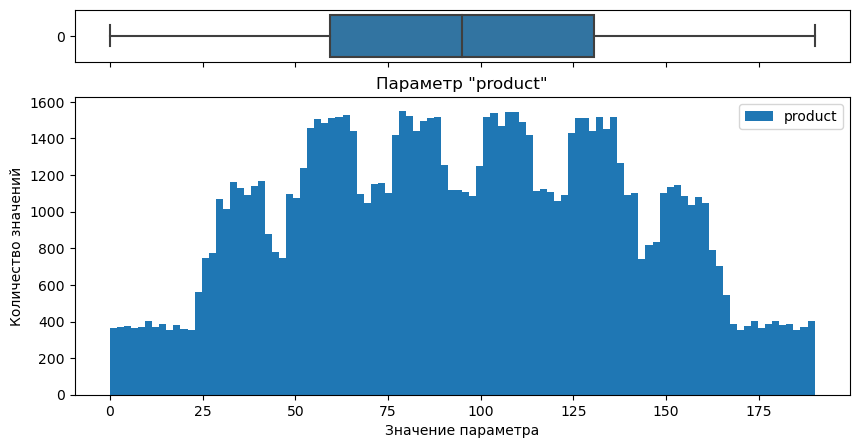

In [27]:
f_hist_box_1(
    hb1=geo_data_2['product'],
    bins=100,   
    title='Параметр "product"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

Сопоставим данные.

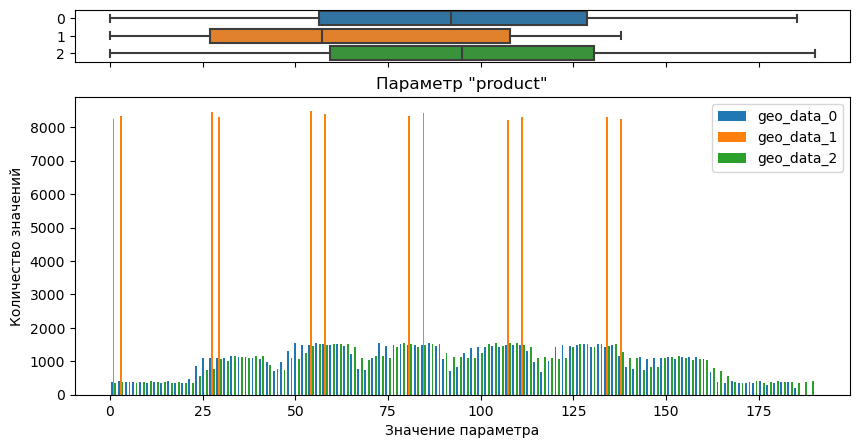

In [28]:
f_hist_box_3(
    hb1=geo_data_0['product'],
    hb2=geo_data_1['product'],
    hb3=geo_data_2['product'],
    bins=100,
    title='Параметр "product"',
    xlabel='Значение параметра',
    ylabel='Количество значений'
)

В данных обнаружено большое количество выбросов, но разброс относительно медианны более-менее равномерный. Значения по регионам отличаются по всем параметрам. Можем приступить к корреляционному анализу данных.

### 1.5. Корреляционный анализ данных

Корреляция данных `geo_data_0`.

In [29]:
interval_cols = ['f0', 
                 'f1', 
                 'f2', 
                 'product'
                ]

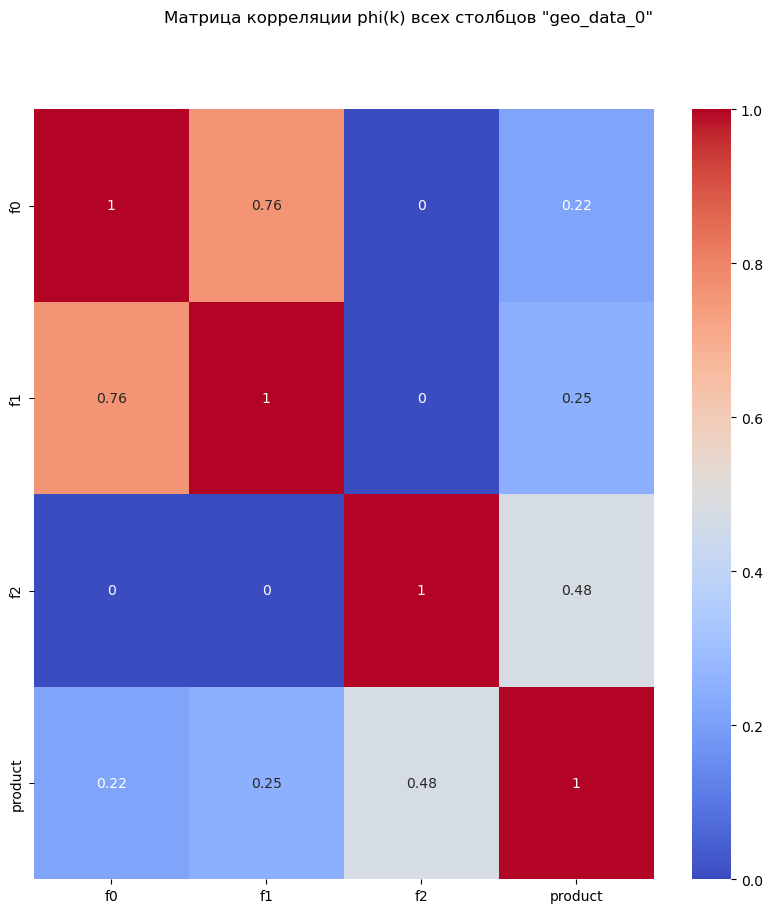

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "geo_data_0"')
sns.heatmap(geo_data_0.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Корреляция данных `geo_data_1`.

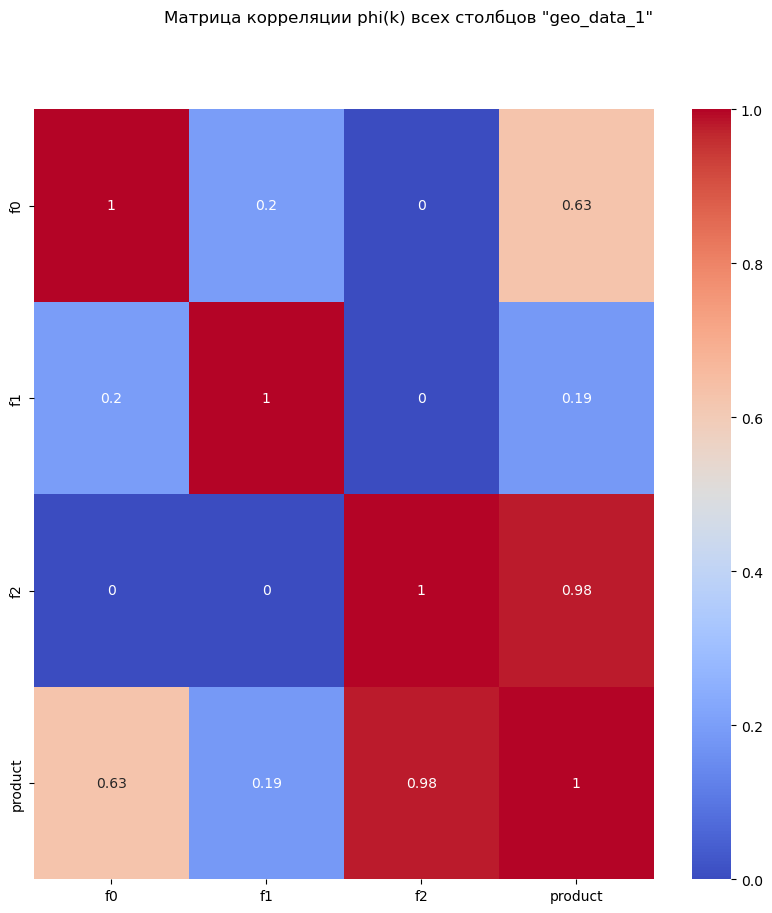

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "geo_data_1"')
sns.heatmap(geo_data_1.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Корреляция данных `geo_data_2`.

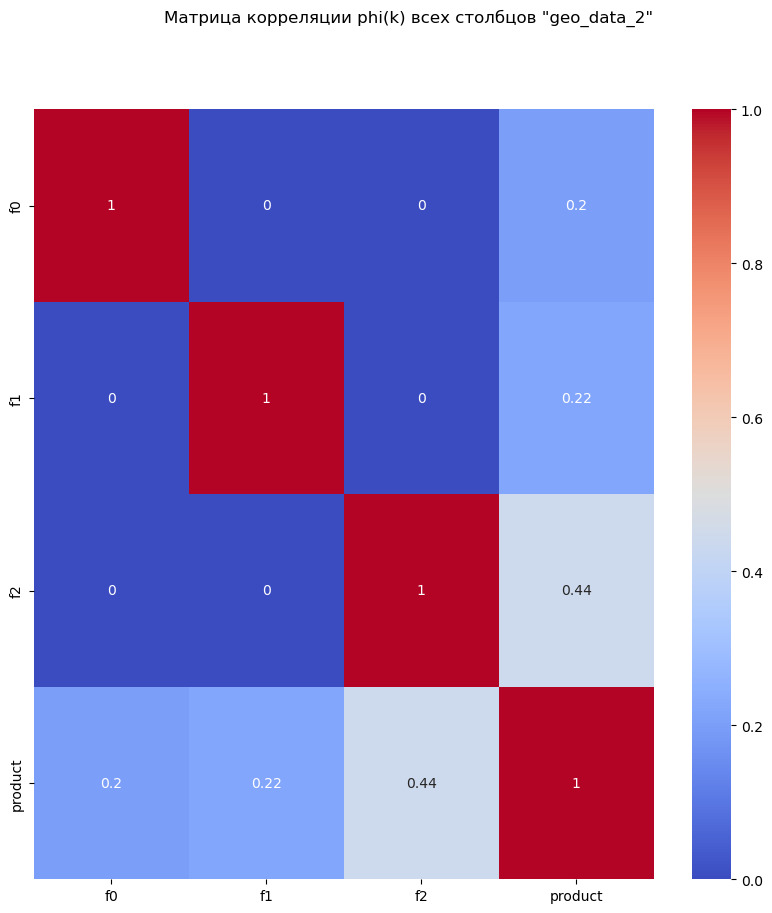

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.suptitle('Матрица корреляции phi(k) всех столбцов "geo_data_2"')
sns.heatmap(geo_data_2.phik_matrix(interval_cols=interval_cols), annot=True, cmap='coolwarm');

Проведен корреляционный анализ данных. В даных обнаружены выбросы но разброс относительно медианы более-менее равномерный. Между входными параметрами данных по всем регионам отсутствует связь выше 0.9, следовательно при обучении модели не нужно учитывать мультиколлинеарность (максимальное значение корреляция phi(k) учитывает нелинейную зависимость и возвращается к коэффициенту корреляции Пирсона в случае бинарного нормального распределения входных данных). Между признаками и целевым показателем по регионам значения разные. В данных `geo_data_1` прослеживается прямая зависимость (phi(k) = 0,98) между входным параметром `f2` и целевым признаком `product`.

#### Вывод по загрузке и подготовке данных
+ Данные загружены. 
+ Пропуски в данных отсутствуют, типы данных соответствуют содержанию.
+ В данных обнаружено большое количество выбросов, но разброс относительно медианны примерно равномерный.
+ Значения по регионам значительно отличаются по всем параметрам.
+ Между входными параметрами данных по всем регионам отсутствует связь выше 0,9 следовательно при обучении модели учитывать мультиколлинеарность не надо.
+ Между признаками и целевым показателем по регионам значения разные. 
+ В данных `geo_data_1` прослеживается прямая зависимость (phi(k) = 0,98) между входным параметром `f2` и целевым признаком `product`.

Перейдем к обучению и проверке модели.

## 2. Обучение и проверка модели

По условию задачи: для обучения модели подходит только линейная регрессия, т.к. остальные недостаточно предсказуемые.

In [33]:
RANDOM_STATE = 42

names = ['geo_predict_0', 'geo_predict_1', 'geo_predict_2']
data = [geo_data_0, geo_data_1, geo_data_2]
targets_1 = {}
targets = {}

for name, data in zip(names, data):
    
    X = data.drop(columns='product')
    y = data['product']

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y,
        random_state=RANDOM_STATE
    )
    
    param_grid = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(), 
                              'passthrough']   
    },

    ]
    
    num_columns = ['f0', 'f1', 'f2']
    data_preprocessor = ColumnTransformer(
    [('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
    )


    pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
    ])

    rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
    )

    rs.fit(X_train, y_train)
    
    targets_1[name] =  pd.concat([pd.DataFrame(y).reset_index(), pd.DataFrame(data=rs.predict(X), columns=['predict'])], axis=1)
    
    targets[name] =  pd.concat([pd.DataFrame(y_test).reset_index(), pd.DataFrame(data=rs.predict(X_test), columns=['predict'])], axis=1)
    print(f'Для данных "{name}" выборка поделена на Обучающую : Валидационную в размере {X_train.shape[0]/X.shape[0]}:{X_test.shape[0]/X.shape[0]}')
    print('-----')
    print(f'Метрика лучшей модели на кросс-валидации:{(abs(rs.best_score_)**0.5):.3f}')
    print('-----')
    rmse_train = (mean_squared_error(y_train, rs.predict(X_train)))**0.5
    print(f'Значение RMSE  на обучающей выборке: {rmse_train:.3f}')
    rmse_test = (mean_squared_error(y_test, rs.predict(X_test)))**0.5
    print(f'Значение RMSE  на тестовой выборке: {rmse_test:.3f}')
    print('-----')
    print(f'Средний запас фактического сырья по валидационной выборке = {y_test.mean():.2f} тыс. баррелей')
    print(f'Средний запас предсказанного сырья по валидационной выборке = {rs.predict(X_test).mean():.2f} тыс. баррелей')
    print(f'Разница = {(1-y_test.mean().mean()/rs.predict(X_test).mean()):.2%}')  
    print( )

Для данных "geo_predict_0" выборка поделена на Обучающую : Валидационную в размере 0.75:0.25
-----
Метрика лучшей модели на кросс-валидации:37.673
-----
Значение RMSE  на обучающей выборке: 37.670
Значение RMSE  на тестовой выборке: 37.757
-----
Средний запас фактического сырья по валидационной выборке = 92.33 тыс. баррелей
Средний запас предсказанного сырья по валидационной выборке = 92.40 тыс. баррелей
Разница = 0.08%

Для данных "geo_predict_1" выборка поделена на Обучающую : Валидационную в размере 0.75:0.25
-----
Метрика лучшей модели на кросс-валидации:0.890
-----
Значение RMSE  на обучающей выборке: 0.890
Значение RMSE  на тестовой выборке: 0.890
-----
Средний запас фактического сырья по валидационной выборке = 68.73 тыс. баррелей
Средний запас предсказанного сырья по валидационной выборке = 68.71 тыс. баррелей
Разница = -0.02%

Для данных "geo_predict_2" выборка поделена на Обучающую : Валидационную в размере 0.75:0.25
-----
Метрика лучшей модели на кросс-валидации:40.027
-----

#### Вывод по обучению и проверке модели
+ Данные разбиты на обучающую и валидационную выборки в соотношении 75:25.
+ Обучена модель и сделаны предсказания на валидационной выборке.
+ Сохранены предсказания и правильные ответы на валидационной выборке в `targets`.
+ Расчитан средний запас предсказанного сырья на валидационной выборке.
+ Расчитаны RMSE модели.

Анализ результатов:
Показатель RMSE на тестовой выборке для данных `geo_predict_1` составляет 0.890, а для `geo_predict_0` и `geo_predict_2` 37.757 и 40.146 соответственно, что указывает на большой разброс данных и отсутствие прямой зависимости между входными и целевым показателями, значит предсказанные значения не отражают реальные запасы сырья с высокой точностью.

## 3. Подготовка к расчёту прибыли

### 3.1. Сохранение ключевых значений для расчетов в отдельные переменрные 

In [34]:
# Количество скважин, которое исследуют при разведке региона
POINTS = 500 
# Количество лучших скважин, которые нужно выбрать для разработки в каждом регионе с помощью машинного обучения
BEST_POINTS = 200 
# Бюджет на разработку скважин в регионе (тыс. рублей), заложенный на 200 скважин
BUDGET = 10e9
# Доход с каждой единицы продукта (тыс. рублей на 1 тыс. баррелей)
BARREL_PRICE = 450_000
# Предел вероятности убытков
LIMIT = 0.025

### 3.2. Расчет достаточного объема сырья для разработки новой скважины

In [35]:
names = ["geo_predict_0", "geo_predict_1", "geo_predict_2"]
data = [geo_data_0, geo_data_1, geo_data_2]

break_even = BUDGET / (BARREL_PRICE * BEST_POINTS)
print(f'Достаточный объём сырья для безубыточной разработки = {break_even:.2f} тыс. баррелей.')

for name, data in zip(names, data):
    print()
    print(f'Средний запас в {name} регионе = {data["product"].mean():.2f} тыс. баррелей.')
    
    print(f'Количество скважин c объёмом больше {break_even:.2f} тыс. баррелей по исходным данным = \
{len(targets_1[name].query("product > @break_even"))} или \
{len(targets_1[name].query("product > @break_even")) / len(targets_1[name]):.2%}')

    print(f'Количество скважин c объёмом больше {break_even:.2f} тыс. баррелей по предсказанным данным = \
{len(targets_1[name].query("predict > @break_even"))} или \
{len(targets_1[name].query("predict > @break_even")) / len(targets_1[name]):.2%}')
    
    print(f'Количество скважин c объёмом больше {break_even:.2f} тыс. баррелей по верификационным данным = \
{len(targets[name].query("predict > @break_even"))} или \
{len(targets[name].query("predict > @break_even")) / len(targets[name]):.2%}')


Достаточный объём сырья для безубыточной разработки = 111.11 тыс. баррелей.

Средний запас в geo_predict_0 регионе = 92.50 тыс. баррелей.
Количество скважин c объёмом больше 111.11 тыс. баррелей по исходным данным = 36583 или 36.58%
Количество скважин c объёмом больше 111.11 тыс. баррелей по предсказанным данным = 21471 или 21.47%
Количество скважин c объёмом больше 111.11 тыс. баррелей по верификационным данным = 5258 или 21.03%

Средний запас в geo_predict_1 регионе = 68.83 тыс. баррелей.
Количество скважин c объёмом больше 111.11 тыс. баррелей по исходным данным = 16537 или 16.54%
Количество скважин c объёмом больше 111.11 тыс. баррелей по предсказанным данным = 18185 или 18.19%
Количество скважин c объёмом больше 111.11 тыс. баррелей по верификационным данным = 4520 или 18.08%

Средний запас в geo_predict_2 регионе = 95.00 тыс. баррелей.
Количество скважин c объёмом больше 111.11 тыс. баррелей по исходным данным = 38178 или 38.18%
Количество скважин c объёмом больше 111.11 тыс. бар

#### Вывод по подготовке расчёта прибыли
+ Все ключевые значения для расчётов сохранены в отдельных переменных.
+ Достаточный объём сырья скважины для безубыточной разработки составляет 111.11 тыс. баррелей. Он превышает средние запасы по всем регионам, что может привести к убыткам при неправильном выборе разработки скважин.

## 4. Расчёт прибыли и рисков 

### 4.1. Создание функции расчёта прибыли

Функция расчёта прибыли по выбранным скважинам и предсказаниям модели должна выполнять:
+ Отбор скважин с максимальными значениями предсказаний. 
+ Сумма целевого значения объёма сырья, соответствующее этим предсказаниям.
+ Расчёт прибыли для полученного объёма сырья.

In [36]:
def f_profit(product_sample, predict_sample, count):
    predict_sample = predict_sample[~predict_sample.index.duplicated()]
    probs_sorted = predict_sample.sort_values(ascending=False)[:count]
    selected = product_sample[probs_sorted.index]
    return selected.sum() * BARREL_PRICE - BUDGET

Функция расчета прибыли по выбранным скважинам подготовлена.

### 4.2. Подсчёт рисков и прибыли для каждого региона

Для региона: geo_predict_0 риск 4.20% > 2.50% 


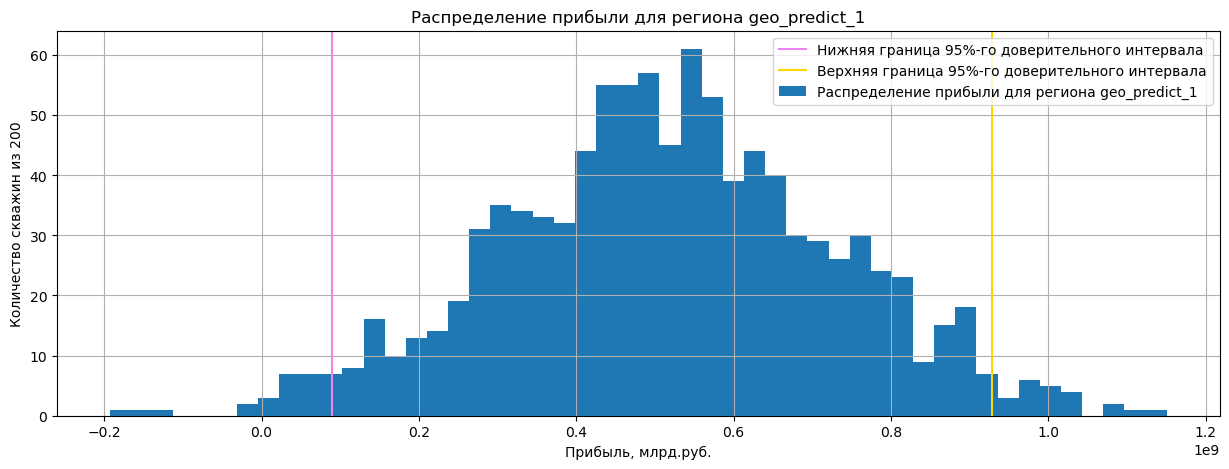


Для geo_predict_1 региона:
Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = 516 млн. рублей.
Доверительный интервал лежит между 89 - 928 млн. рублей.
Риск убытков составляет = 0.60%
Для региона: geo_predict_2 риск 5.10% > 2.50% 


In [37]:
STATE = np.random.RandomState(12345)

for name in names:
    values = []
    for i in range(1000):
        product_sample = targets[name]['product'].sample(POINTS, replace=True, random_state=STATE)
        predict_sample = targets[name]['predict'][product_sample.index]
        values.append(f_profit(product_sample, predict_sample, BEST_POINTS))
        
    values = pd.Series(values)
     
    mean = values.mean() / 1_000_000
    lower = values.quantile(0.025) / 1_000_000
    upper = values.quantile(0.975) / 1_000_000
    
    risk = values.apply(lambda x: x < 0).sum() / len(values)
    if risk > LIMIT:
        print(f'Для региона: {name} риск {risk:.2%} > {LIMIT:.2%} ')
        continue
    
    values.hist(figsize=(15, 5), bins=50)
    plt.grid(True)
    plt.axvline(values.quantile(0.025), color='violet')
    plt.axvline(values.quantile(0.975), color='gold')
    plt.legend(['Нижняя граница 95%-го доверительного интервала', 
                'Верхняя граница 95%-го доверительного интервала', f'Распределение прибыли для региона {name}'])
    plt.xlabel('Прибыль, млрд.руб.')
    plt.ylabel('Количество скважин из 200')
    plt.title(f'Распределение прибыли для региона {name}')
    plt.show()

    print()
    print(f'Для {name} региона:')
    print(f'Средняя валовая прибыль с 200 лучших скважин, отобраных по предсказанию = {mean:.0f} млн. рублей.')
    print(f'Доверительный интервал лежит между {lower:.0f} - {upper:.0f} млн. рублей.')
    print(f'Риск убытков составляет = {risk:.2%}')

### Вывод по расчёту прибыли и рисков

+ Для распределения прибыли применена техника Bootstrap на 1000 выборок (случайный выбор 500 скважин в регионе по предсказанным данным по каждому региону), отбор из них 200 с максимальным запасом и расчёт распределения прибыли.
+ Расчитана средняя прибыль по регионам при случайном выборе 500 скважин.
+ Расчитан риск возникновения убытков при случайном отборе 500 скважин.
+ Расчитан 95%-й доверительный интервал для каждого региона при случайном отборе 500 скважин.
+ Отобраны регионы удовлетворяющие условию (возникновение риска < 2.5%)  и построены для них гистограммы распределения прибыли, при случайном отборе 500 скважин.

Перспективным регионом для разработки послее оценки рисков является `geo_predict_1`, в котором вероятность убытков меньше 2.5%, при этом средняя прибыль по нему составляет 516 млн. руб., доверительный интервал 89 - 928 млн. рублей и риск возникновения убытков 0,60%

## 5. Выводы

По результатам проведенного анализа рекомендуется выбрать регион для разработки с данными `geo_predict_1`, в котором риск возникновения убытков 0,60% (при случайном выборе 500 скважин и отборе 200 лучших из них), что меньше допкстимого уровня в 2,5%. Средняя прибыль по этому региону составит 516 млн. руб., при 95% доверительном интервале 89 - 928 млн. руб. Для снижения рисков и увеличения прибыли предлагается отбирать скважины для разработки с разведаным запасом нефти более 111,11 тыс. баррелей.